In [1]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [14]:
# inputting the image from 
input_img = "im1_pn_normal.jpeg"

#saving the images that we have into vector variables
img = cv2.imread(input_img,0)


In [15]:
# the following command will help us understand what the image will look like (vectorized)
img = img/255
# this is going to show us the dimensions of the image  (we can make adjustments based off this)



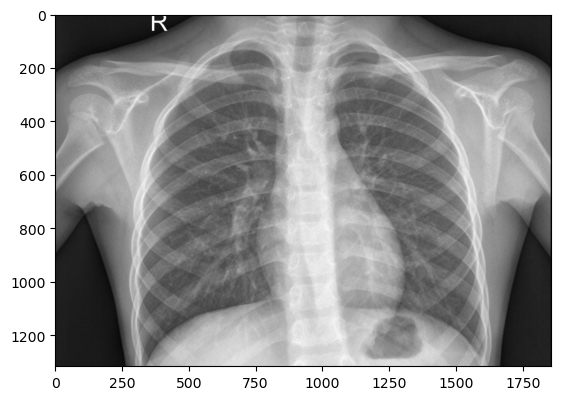

In [16]:
plt.imshow(img,cmap='gray')

*Looking* at the first and last row, we see that there is a black border on the image. To remove this, we can take out the first and last column of the image. Thought the black border is not significant, it is important to remove these things because they add to the external noise that we have. We can do this in the following cell.

In [18]:
k = 8
N = 10000
patch = image.extract_patches_2d(img, (k, k), max_patches = N, random_state=None) # change the max_patches number as well as random_state # change around the random_state value
patch.shape

(10000, 8, 8)

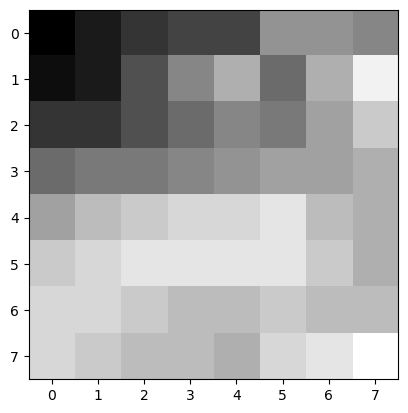

In [19]:
import random


plt.imshow(255*patch[random.randint(0,N)],cmap='gray')

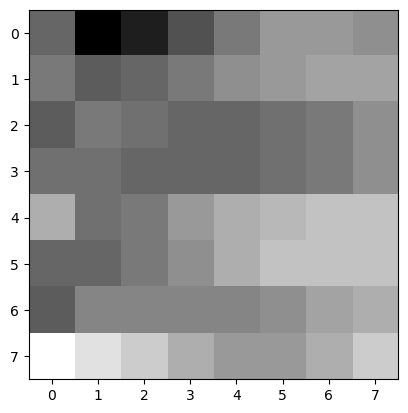

In [20]:
plt.imshow(patch[0],cmap='gray')

Moving on to the Autoencoder
The first thing we would have to do in this place is import our the PyTorch libraries that we are going to use.

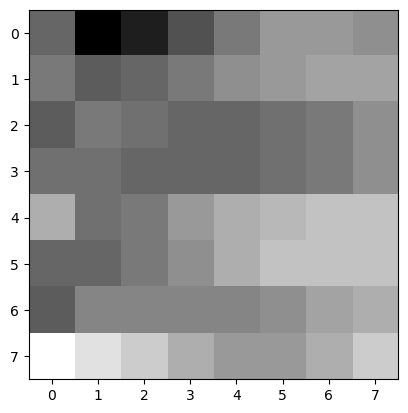

In [21]:
plt.imshow(patch[0],cmap='gray')

In [22]:
import torch
from torchvision import datasets
from torchvision import transforms

In [23]:
patchtensor = torch.from_numpy(patch)
print(patchtensor.data.shape)
type(patchtensor)

torch.Size([10000, 8, 8])


torch.Tensor

In [24]:
# DataLoader is used to load the dataset
# for training
patchloader = torch.utils.data.DataLoader(dataset = patchtensor, batch_size = 32, shuffle = True)


The creation of the Autoencoder
1024 = 32*32 ==> 625 (25^2) ==> 400 (20^2) ==> 225 (15^2) ==> 144 (12^2) ==> 121 (11^2) ==> 100

100 ==> 121 ==> 144 ==> 225 ==> 400 ==> 625 ==> 32*32 = 1024

In [31]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28 # change these values
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9

        #grow first and then shrink
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(k * k, 2000),  # change these values, these are not big enough ## change the 32^2 to maybe 2048
            torch.nn.ReLU(),
            torch.nn.Linear(2000, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 100),
        )
    
        '''
        what can we do with the compressed form of the nn?
        can we take this nn and put it somewhere else so that it can work as transfer of data with much less information
        '''

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 2000),
            torch.nn.ReLU(),
            torch.nn.Linear(2000, k * k),
            torch.nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [34]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001,
                             weight_decay = 1e-8)


In [35]:
epochs = 300 #change the epoch value to be larger
outputs = []
losses = []
for epoch in range(epochs):
#     print(epoch)
    for image in patchloader:
        image = image.reshape(-1, k*k)# Reshaping the image to (-1, 784)
        image = image.float()

    # Output of Autoencoder
        reconstructed = model(image)

    # Calculating the loss function
        loss = loss_function(reconstructed, image)

    # The gradients are set to zero,
    # the gradient is computed and stored.
    # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Storing the losses in a list for plotting
        losses.append(loss)
        outputs.append((epochs, image, reconstructed))
    print('epoch [{}/{}], loss:{:.8f}'
          .format(epoch + 1, epochs, loss.data.detach().numpy()))



epoch [1/300], loss:0.06043266
epoch [2/300], loss:0.07363702
epoch [3/300], loss:0.06667658
epoch [4/300], loss:0.06946521
epoch [5/300], loss:0.05480300
epoch [6/300], loss:0.09153187
epoch [7/300], loss:0.09710239
epoch [8/300], loss:0.07143620
epoch [9/300], loss:0.05849411
epoch [10/300], loss:0.07478226
epoch [11/300], loss:0.04704268
epoch [12/300], loss:0.04389136
epoch [13/300], loss:0.05445882
epoch [14/300], loss:0.07093597
epoch [15/300], loss:0.03857058
epoch [16/300], loss:0.06691921
epoch [17/300], loss:0.03768803
epoch [18/300], loss:0.03415191
epoch [19/300], loss:0.03639372
epoch [20/300], loss:0.02984835
epoch [21/300], loss:0.02684358
epoch [22/300], loss:0.02178157
epoch [23/300], loss:0.02118569
epoch [24/300], loss:0.01869550
epoch [25/300], loss:0.01947327
epoch [26/300], loss:0.01767271
epoch [27/300], loss:0.02130970
epoch [28/300], loss:0.02158368
epoch [29/300], loss:0.02246304
epoch [30/300], loss:0.03109796
epoch [31/300], loss:0.02552317
epoch [32/300], l

Text(0, 0.5, 'Loss')

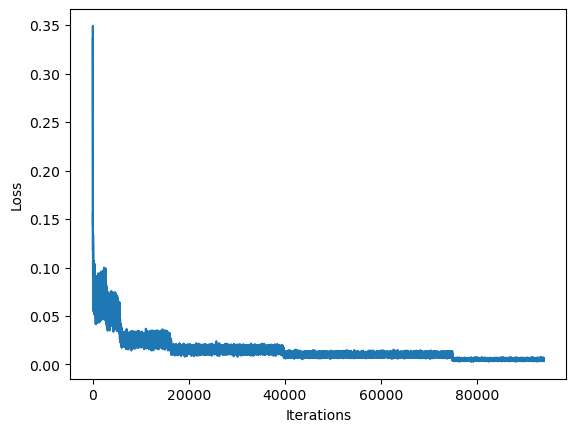

In [36]:
l = []
for j in range(len(losses)):
    a = losses[j].detach().numpy()
    l.append(a)

# Defining the Plot Style
plt.plot(l)
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

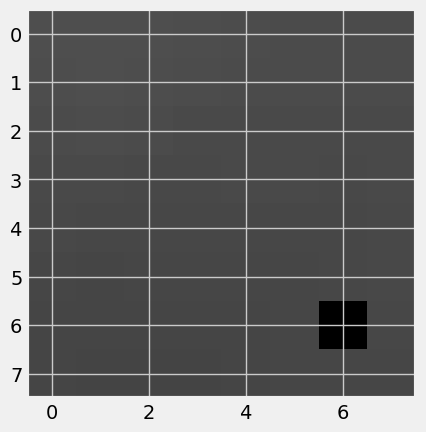

In [44]:
# print(reconstructed.shape)
for i, item in enumerate(reconstructed):
    item = item.reshape(-1, k, k)
    plt.imshow(item[0].detach().numpy(),cmap='gray',vmin=0, vmax=1)
#     plt.show()

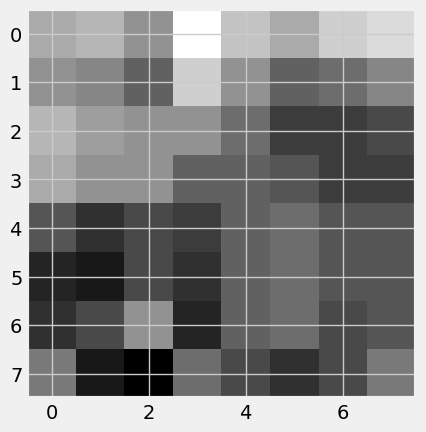

In [41]:
for i, item in enumerate(image):
    # Reshape the array for plotting
    item = item.reshape(-1, k, k)
    plt.imshow(item[0],cmap='gray')
